In [27]:
# %% Setup and Import
import numpy as np
from scipy.stats import lognorm, gaussian_kde
from scipy.optimize import minimize
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

np.random.seed(123)

In [17]:
# %% Literature definitions for nodule distributions
# Gould-style bins for largest nodule, 4–30 mm
edges = np.array([4, 5, 8, 12, 20, 30])

# Target proportions in each bin (conditional on 4–30 mm)
target_props = np.array([0.24, 0.21, 0.18, 0.22, 0.15])

target_props.sum()


np.float64(0.9999999999999999)

In [21]:
def truncated_lognorm_bin_probs(mu, log_sigma, edges):
    """
    Given meanlog=mu and log_sigma=log(sigma),
    return conditional bin probabilities over [edges[0], edges[-1]].
    """
    sigma = np.exp(log_sigma)
    dist = lognorm(s=sigma, scale=np.exp(mu))

    F_edges = dist.cdf(edges)

    # Normalizing constant over [4,30]
    Z = F_edges[-1] - F_edges[0]

    # Mirror the R behavior: if essentially zero mass in [4,30], kill it
    if (not np.isfinite(Z)) or (Z < 1e-6):
        return np.full(len(edges) - 1, np.nan)

    p_bins = np.diff(F_edges) / Z
    return p_bins


def objective(params, edges, target_props):
    mu, log_sigma = params
    p_bins = truncated_lognorm_bin_probs(mu, log_sigma, edges)
    if np.any(~np.isfinite(p_bins)):
        return 1e6
    return np.sum((p_bins - target_props) ** 2)


In [22]:
from scipy.optimize import minimize

mu_init = 2.3
log_sigma_init = np.log(0.6)

res = minimize(
    objective,
    x0=np.array([mu_init, log_sigma_init]),
    args=(edges, target_props),
    method="L-BFGS-B",
    bounds=[(1.0, 3.0), (np.log(0.2), np.log(1.5))],  # bounds on mu, log_sigma
    options={"maxiter": 2000, "disp": True}
)

mu_hat, log_sigma_hat = res.x
sigma_hat = np.exp(log_sigma_hat)

print("Fitted parameters:")
print(f"  meanlog (mu_hat)   = {mu_hat:.4f}")
print(f"  sdlog  (sigma_hat) = {sigma_hat:.4f}")

p_fit = truncated_lognorm_bin_probs(mu_hat, log_sigma_hat, edges)

print("\nBin matches (target vs fit):")
for i in range(len(target_props)):
    print(
        f"{edges[i]:>2.0f}–{edges[i+1]:<2.0f} mm: "
        f"target = {target_props[i]:.3f},  fit = {p_fit[i]:.3f}"
    )


Fitted parameters:
  meanlog (mu_hat)   = 1.4747
  sdlog  (sigma_hat) = 1.5000

Bin matches (target vs fit):
 4–5  mm: target = 0.240,  fit = 0.140
 5–8  mm: target = 0.210,  fit = 0.285
 8–12 mm: target = 0.180,  fit = 0.220
12–20 mm: target = 0.220,  fit = 0.224
20–30 mm: target = 0.150,  fit = 0.132


In [23]:
# %%
mu_hat, log_sigma_hat = res.x
sigma_hat = np.exp(log_sigma_hat)

print("Fitted parameters:")
print(f"  meanlog (mu_hat)   = {mu_hat:.4f}")
print(f"  sdlog  (sigma_hat) = {sigma_hat:.4f}")

p_fit = truncated_lognorm_bin_probs(mu_hat, log_sigma_hat, edges)

print("\nBin matches (target vs fit):")
for i in range(len(target_props)):
    print(
        f"{edges[i]:>2.0f}–{edges[i+1]:<2.0f} mm: "
        f"target = {target_props[i]:.3f},  fit = {p_fit[i]:.3f}"
    )


Fitted parameters:
  meanlog (mu_hat)   = 1.4747
  sdlog  (sigma_hat) = 1.5000

Bin matches (target vs fit):
 4–5  mm: target = 0.240,  fit = 0.140
 5–8  mm: target = 0.210,  fit = 0.285
 8–12 mm: target = 0.180,  fit = 0.220
12–20 mm: target = 0.220,  fit = 0.224
20–30 mm: target = 0.150,  fit = 0.132


In [20]:
# %%
def r_truncated_lognorm(n, meanlog, sdlog, xmin=4.0, xmax=30.0):
    """
    Fast truncated lognormal sampler:
    log(X) ~ N(meanlog, sdlog^2), truncated to [log(xmin), log(xmax)].
    """
    # sanity check: interval has non-negligible probability
    dist_full = lognorm(s=sdlog, scale=np.exp(meanlog))
    p_int = dist_full.cdf(xmax) - dist_full.cdf(xmin)
    if (not np.isfinite(p_int)) or (p_int < 1e-8):
        raise ValueError(
            f"Truncation [{xmin}, {xmax}] has essentially zero prob (p={p_int:.2e}) "
            f"under lognormal(meanlog={meanlog:.3f}, sdlog={sdlog:.3f})."
        )
    
    # transform to standard normal on log-scale
    a = (np.log(xmin) - meanlog) / sdlog
    b = (np.log(xmax) - meanlog) / sdlog
    
    # sample Z ~ N(0,1) truncated to [a,b]
    z = truncnorm.rvs(a, b, loc=0, scale=1, size=n)
    return np.exp(meanlog + sdlog * z)


In [28]:
# %%
N_all = 50000  # total PCP-world nodules (choose scale)

size_all = r_truncated_lognorm(
    n=N_all,
    meanlog=mu_hat,
    sdlog=sigma_hat,
    xmin=4.0,
    xmax=30.0
)

size_all_orig = size_all.copy()  # keep full PCP pool


In [29]:
# %%
N_lit = 10000

# choose bin index for each literature nodule
bin_ids = np.random.choice(
    np.arange(len(target_props)),
    size=N_lit,
    p=target_props
)

size_lit = np.empty(N_lit)
for i, b in enumerate(bin_ids):
    low = edges[b]
    high = edges[b + 1]
    size_lit[i] = np.random.uniform(low, high)

size_lit[:10]


array([ 7.57383115,  4.43829028,  8.15376091, 10.87661723, 10.17568467,
        6.15056876,  8.77747485,  4.23866547,  8.5563058 , 26.68618204])

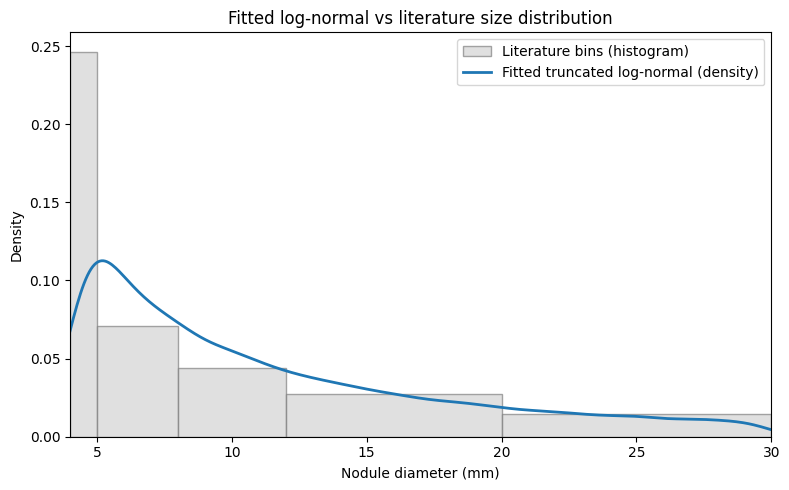

In [30]:
# %%
plt.figure(figsize=(8, 5))

# Literature histogram as density
plt.hist(
    size_lit,
    bins=edges,
    density=True,
    alpha=0.7,
    color="lightgray",
    edgecolor="gray",
    label="Literature bins (histogram)"
)

# Simulated density using KDE
kde = gaussian_kde(size_all)
x_vals = np.linspace(4, 30, 400)
y_vals = kde(x_vals)

plt.plot(
    x_vals,
    y_vals,
    linewidth=2,
    label="Fitted truncated log-normal (density)"
)

plt.xlabel("Nodule diameter (mm)")
plt.ylabel("Density")
plt.title("Fitted log-normal vs literature size distribution")
plt.xlim(4, 30)
plt.legend()
plt.tight_layout()
plt.show()
